# defines a 3D, 3DOF, human configured arm from the shoulder to wrist

In [2]:
from sympy import symbols, cse, Function, diff, MatrixSymbol, Eq, BlockMatrix, Matrix
from sympy import latex 

from sympy.physics.mechanics import dynamicsymbols, ReferenceFrame, Point,\
kinetic_energy, potential_energy, inertia, RigidBody, Lagrangian, \
LagrangesMethod, init_vprinting, msubs

init_vprinting()

from sympy.physics.matrices import Matrix

#from sympy.utilities.lambdify import lambdify, implemented_function

#import numpy

#from pydy.codegen.ode_function_generators import generate_ode_function

from sympy.utilities.codegen import codegen, Routine

from sympy.printing.cxxcode import CXX11CodePrinter
from sympy.printing.ccode import C99CodePrinter

from u_io import u_IO

# system modifications from other domains (FEA, motor modeling) would have to go here before mass properties & link lengths

In [2]:
# reference frames - need to start the link simplification from here

GroundFrame = ReferenceFrame('F_g')

link01Frame    = ReferenceFrame('F_{1}')
link02Frame    = ReferenceFrame('F_{2}')
link03Frame    = ReferenceFrame('F_{3}')

framelist = [GroundFrame,link01Frame,link02Frame,link03Frame]

In [3]:
# coordinates and states
th1,th2,th3         = dynamicsymbols('theta1,theta2,theta3')
th1d,th2d,th3d     = dynamicsymbols('theta1,theta2,theta3',1)
th1dd,th2dd,th3dd = dynamicsymbols('theta1,theta2,theta3',2)

om1,om2,om3        = dynamicsymbols('omega1,omega2,omega3')
omd1,omd2,omd3     = dynamicsymbols('omega1,omega2,omega3',1)


q   = Matrix([th1,  th2,  th3])

qd  = Matrix([th1d, th2d, th3d])
#qd  = Matrix([om1, om2, om3])

qdd = Matrix([th1dd,th2dd,th3dd])
#qdd = Matrix([omd1, omd2, omd3])

xst   = Matrix([*q,  *qd])
xdst  = Matrix([*qd, *qdd])

In [4]:
# aligning frames

link01Frame.orient(GroundFrame, 'Axis',(th1,GroundFrame.z))
link02Frame.orient(link01Frame, 'Axis',(th2,link01Frame.x))
link03Frame.orient(link02Frame, 'Axis',(th3,link02Frame.x))


link01Frame.set_ang_vel(GroundFrame, th1d*GroundFrame.z)
link02Frame.set_ang_vel(link01Frame, th2d*link01Frame.x)
link03Frame.set_ang_vel(link02Frame, th3d*link02Frame.x)

In [5]:
# defining joint positions & velocities

shoulder = Point('shoulder') 
shoulder.set_vel(GroundFrame,0)

elbow = Point('elbow')
#UpArmLen = .2
UpArmLen = symbols('L_{ua}')
elbow.set_pos(shoulder , UpArmLen * link01Frame.x)
elbow.v2pt_theory(shoulder,GroundFrame,link02Frame);

wrist = Point('wrist')
wrist.set_pos(elbow , UpArmLen*link03Frame.z);
wrist.v2pt_theory(elbow,GroundFrame,link03Frame);

In [6]:
# setting positions of centers of mass

l1com = Point('l1com')
l2com = Point('l2com')
l3com = Point('l3com')

l1com.set_pos(shoulder, 0)
l2com.set_pos(shoulder, .5*UpArmLen*link02Frame.z)
l3com.set_pos(elbow, .5*UpArmLen*link03Frame.z)



l1com.v2pt_theory(shoulder,GroundFrame,link01Frame);
l2com.v2pt_theory(shoulder,GroundFrame,link02Frame);
l3com.v2pt_theory(shoulder,GroundFrame,link03Frame);

In [7]:
# link masses and inertias
m_b, m_r = symbols('m_b m_r')
Jx, Jz, jzshoulder= symbols('J_x J_z J_zs')

# inertia dyadics
JShoulder = inertia(link01Frame,0,0,jzshoulder,ixy=0,iyz=0,izx=0)
JUpper    = inertia(link02Frame,Jx,Jx,Jz,      ixy=0,iyz=0,izx=0)
JFore     = inertia(link03Frame,Jx,Jx,Jz,      ixy=0,iyz=0,izx=0)

# JFore.to_matrix(link04Frame) # produces a tensor from the dyadic

In [8]:
# Defining rigid bodies with the rigid body class

link01 = RigidBody('Shoulder', l1com, link01Frame, m_b, (JShoulder, l1com))
link02 = RigidBody('UpperArm', l2com, link02Frame, m_r, (JUpper   , l2com))
link03 = RigidBody('LowerArm', l3com, link03Frame, m_r, (JFore    , l3com))


In [9]:
# Potential energy definition

g = symbols('g')

link01.potential_energy = link01.mass * GroundFrame.y.dot(l1com.pos_from(shoulder)) * g
link02.potential_energy = link02.mass * GroundFrame.y.dot(l2com.pos_from(shoulder)) * g
link03.potential_energy = link03.mass * GroundFrame.y.dot(l3com.pos_from(shoulder)) * g

# The Lagrangian

In [10]:
L = Lagrangian(GroundFrame,link01,link02,link03)

In [11]:
sys = LagrangesMethod(L,q)
#sys = LagrangesMethod(L,q,forcelist=u_list,frame=GroundFrame)

In [12]:
# defining nonlinear system

sys.form_lagranges_equations();

D = sys.mass_matrix;
H = sys.forcing;


#f_b = sys.forcing;
#B = f_b.jacobian(u)
#H = f_b - B*u


#f_x = D.inv()*H;
#g_x = D.inv()*B;

In [13]:
# defining observer outputs

h1 = wrist.pos_from(shoulder).dot(GroundFrame.x)
h2 = wrist.pos_from(shoulder).dot(GroundFrame.y)
h3 = wrist.pos_from(shoulder).dot(GroundFrame.z)

vwrist = wrist.vel(GroundFrame)

h1d = vwrist.dot(GroundFrame.x)
h2d = vwrist.dot(GroundFrame.y)
h3d = vwrist.dot(GroundFrame.z)

h_x = Matrix([h1,h2,h3])
hd_x = Matrix([h1d,h2d,h3d])

dhdx = h_x.jacobian(xst)
Lfh  = dhdx*xdst
dLie = Lfh.jacobian(xst)

In [14]:
# defining actuator torques & B matrix

tau1,tau2,tau3 = dynamicsymbols('tau1,tau2,tau3')
u = Matrix([tau1,tau2,tau3])

link01torques = tau1*link01Frame.z
link02torques = tau2*link02Frame.x - tau3*link02Frame.z
link03torques = tau3*link03Frame.z



u_list = [(link01Frame,link01torques),(link02Frame,link02torques),
(link03Frame,link03torques)]

E_nc = u.T*q
B = (E_nc.jacobian(u)).jacobian(q)

# Code generation

In [15]:
# Matrix symbols for outputs in code generation

out_Dmat    = MatrixSymbol('out_Dmat',*D.shape)
out_Hvec    = MatrixSymbol('out_Hvec',*H.shape)
out_Bmat    = MatrixSymbol('out_Bmat',*B.shape)
out_dLie    = MatrixSymbol('out_dLie',*dLie.shape)

In [44]:
# state substitution

# subsituting velocities beforehand to avoid issues with derivatives in cse
vsym = symbols('v1 v2 v3')
vmap = dict(zip(qd,vsym))

x_st = xst.xreplace(vmap) # state vector with no velocities

st = MatrixSymbol('st',*xst.shape)

state_array_map = dict(zip(x_st,st))

# parameter substitution
freesymbols_set = H.free_symbols | D.free_symbols | dLie.free_symbols
freesymbols_set.remove(symbols('t'))

freesymbols = Matrix([*freesymbols_set])

par = MatrixSymbol('par',*freesymbols.shape)
parameter_map = dict(zip(freesymbols,par))




fvalmap = {**state_array_map,**parameter_map}

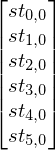

In [43]:
# state vector with all substitutions - prints as indexed if substitutions are correct

x_st.xreplace(fvalmap)

## Generating individual functions with codegen

### single ode matrix symbol equality terms 

Dmat_cgen   = D.xreplace(fvalmap)
Hvec_cgen   = H.xreplace(fvalmap)
Bmat_cgen   = B.xreplace(fvalmap)
dLie_cgen   = dLie.xreplace(fvalmap)

D_eq        = Eq(out_Dmat,Dmat_cgen)
H_eq        = Eq(out_Hvec,Hvec_cgen)
B_eq        = Eq(out_Bmat,Bmat_cgen)
L_eq        = Eq(out_dLie,dLie_cgen)



### single ODE terms written to individual files

[(c_Dmat,c_DmatSource),(h_Dmat,h_DmatSource)]\
= codegen((\
           'c_Dmat',D_eq),\
          language = 'c',\
          argument_sequence = (st,par,out_Dmat),\
          project = 'Robotic System Optimization',\
          global_vars = None,\
          to_files = True
         )

[(c_Hvec,c_HvecSource),(h_Hvec,h_HvecSource)]\
= codegen(('c_Hvec',H_eq),\
          language = 'c',\
          argument_sequence = (st,par,out_Hvec),\
          project = 'Robotic System Optimization')

[(c_dLie,c_dLieSource),(h_dLie,h_dLieSource)]\
= codegen(('c_dLie',L_eq),\
          language = 'c',\
          argument_sequence = (st,par,out_dLie),\
          project = 'Robotic System Optimization')

[(c_Bmat,c_BmatSource),(h_Bmat,h_BmatSource)]\
= codegen(('c_Bmat',B_eq),\
          language = 'c',\
          argument_sequence = (st,par,out_Bmat),\
          project = 'Robotic System Optimization')

## Alternative method of using one single codegen call

ODEeqs = [D_eq,H_eq,B_eq,L_eq] 
[(c_terms,c_terms_source),(h_terms,h_terms_source)]=\
        codegen(('ODEeqs',ODEeqs),\
               language = 'c',\
               argument_sequence = (st,par,out_Dmat,out_Hvec\
                                    ,out_Bmat,out_dLie),\
               project = 'Robotic System Optimization',\
               prefix = 'ODEterms_',\
               to_files = True,\
               header = True\ 
               )

# CSE for all terms simultaneously with code printing

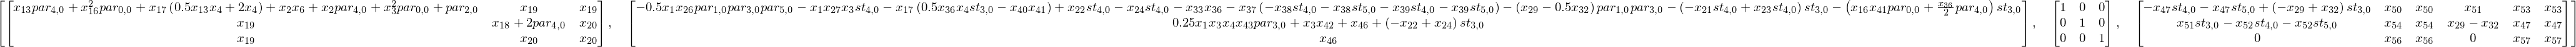

In [50]:
# generating subexpressions

subextemp, ODEtermstemp = cse([D.xreplace(vmap),\
                               H.xreplace(vmap),\
                               B.xreplace(vmap),\
                               dLie.xreplace(vmap)])


subex_mat = Matrix(subextemp).xreplace(fvalmap)
subex_lh  = Matrix(subex_mat[:,0])
subex_rh  = Matrix(subex_mat[:,1])


subvar = []

sub_map = dict(zip(subex_mat[:,0],subvar))

nsubexestemp = subex_lh.shape
nsubexes = nsubexestemp[0]
    

    
ODEterms =[];
for ind in range(0, len(ODEtermstemp)):
    ODEterms.append(ODEtermstemp[ind].xreplace(fvalmap))
    
ODEterms

In [56]:
def fvalreplace(ODEterm):
    return ODEterm.xreplace(fvalmap)

ODEterms = map(fvalreplace, ODEtermstemp) 


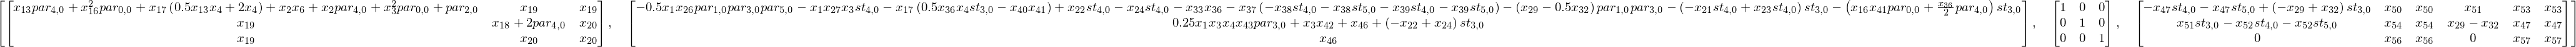

In [49]:
ODEterms = [ODEtermstemp_i.xreplace(fvalmap) for ODEtermstemp_i in ODEtermstemp]
ODEterms

### subclassing a printer for the subexpressions

In [20]:
class CSE_Cpp_printer(CXX11CodePrinter):
    def _print_ImmutableDenseMatrix(self,expression):
        
        lines = []
        
        for idx, expr in enumerate(expression):
            varnum = str(idx)
            lines.append('double ' + 'x' + varnum + ' = ' + self._print(expr))
       
        return '\n'.join(lines) 

In [21]:
csepr = CSE_Cpp_printer()
cpppr = CXX11CodePrinter()

print(\
      csepr.doprint(subex_mat[:,1]) + '\n\n' +\
      cpppr.doprint(ODEterms[0]   , assign_to = out_Dmat)  + '\n \n' +\
      cpppr.doprint(ODEterms[1]   , assign_to = out_Hvec)  + '\n \n' +\
      cpppr.doprint(ODEterms[2]   , assign_to = out_Bmat)  + '\n \n' +\
      cpppr.doprint(ODEterms[3]   , assign_to = out_dLie)  + '\n \n' \
     )

In [22]:
# generating python functions to use in regular python optimization

In [23]:
def ode_terms(st, par):
    
    subvar = []
    
    for ind in range(0,nsubexes):
        subvar.append(subex_mat[ind,1].xreplace(sub_map))
        print(subvar[ind])
    
    odeterms = []
    for ind in range(0,len(ODEterms)):
        odeterms.append(ODEterms[ind].xreplace(sub_map))
    return odeterms

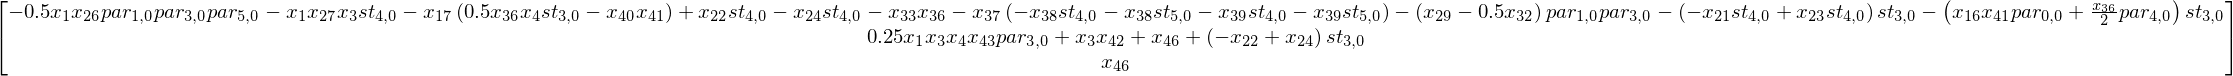

In [24]:
ODEterms[1].xreplace(sub_map)

st[1, 0]
sin(x0)
x1**2
cos(x0)
par[5, 0]**2
x4*par[3, 0]
0.25*x5
st[2, 0]
cos(x7)
x1*x8
sin(x7)
x10*x3
x11 + x9
x12**2
x3*x8
x1*x10
x14 - x15
par[3, 0]/2
0.5*x5
-x16*x18
x6 + par[4, 0]
x1*x3*par[0, 0]
x21*st[3, 0]
x1*x3*par[4, 0]
x23*st[3, 0]
st[0, 0]
sin(x25)
0.5*x4*par[3, 0]*st[3, 0]
cos(x25)
x28*par[5, 0]
x26*par[5, 0]
-x11 - x9
x30*x31
par[4, 0]*st[3, 0]/2
2*x15
2*x14
x12*(-x34*st[4, 0] - x34*st[5, 0] + x35*st[4, 0] + x35*st[5, 0])
x16*par[0, 0]*st[3, 0]/2
2*x9
2*x11
1.0*x4*(st[4, 0] + st[5, 0])
-x11*st[4, 0] - x11*st[5, 0] - x9*st[4, 0] - x9*st[5, 0]
0.5*x28*par[1, 0]*par[3, 0]*par[5, 0]
st[3, 0]**2
-x14 + x15
x12*(-x34 + x35)
x17*(-x31*x40*st[3, 0] + 0.25*x4*x43*x45) + x27*x41 - x42*x44 + (x33*x45 + x37*(-x38 - x39))*st[3, 0]
x29*x44
x12*st[4, 0]
x12*st[5, 0]
-x30*x48 - x30*x49 - x47*st[3, 0]
-x29*x31 - x30
x30*x44
-x52
x29*x48 + x29*x49 - x52*st[3, 0]
x44*par[5, 0]
x55*st[4, 0] + x55*st[5, 0]
x31*par[5, 0]


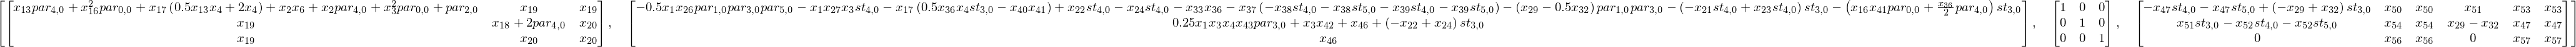

In [25]:
st = Matrix([[0],[0],[0],[0],[0],[0]])
ode_terms(st,par)